In [1]:
# Librerias necesarias
from CoffeaDelphes import Converter
import numpy as np
import matplotlib.pyplot as plt
from hist import Hist
import mplhep as hep
import pandas as pd
import glob
import coffea

plt.style.use([hep.style.ROOT])

import warnings
warnings.filterwarnings('ignore')

In [2]:
runs = ["run_0{}".format(x+1) if x < 9 else "run_{}".format(x+1) for x in range(21) ]
fname = ["/cms/mc/MG5_aMC_v3_1_1/Zbbbar_schannel/Events/{}/tag_1_delphes_events.root".format(run) for run in runs ]

In [3]:
dc =  {"jet_pt0":[],"jet_pt1":[],"jet_pt2":[],"jet_pt3":[],
       "jet_eta0":[],"jet_eta1":[],"jet_eta2":[],"jet_eta3":[],
       "jet_phi0":[],"jet_phi1":[],"jet_phi2":[],"jet_phi3":[],
       'jet_btag0':[], 'jet_btag1':[], 'jet_btag2':[], 'jet_btag3':[],
       'jet_mass0':[], 'jet_mass1':[], 'jet_mass2':[], 'jet_mass3':[],
       'missinget_met':[],'missinget_phi':[]}
df_all = pd.DataFrame(dc)
df_all.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,jet_phi1,...,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,missinget_met,missinget_phi


In [4]:
for index,path in enumerate(fname):
    tree_temp = Converter(path)
    events_temp = {"Jet": ["PT", "Eta", "Phi", "Mass", "BTag"], "MissingET": ["MET", "Phi"]}
    tree_temp.generate(events_temp)
    df_temp = tree_temp.df
    print(index+1,"- Tamaño del dataframe temporal:",len(df_temp))
    df_all = pd.concat([df_all,df_temp], ignore_index=True)
print("Tamaño del dataframe total es:",len(df_all))

1 - Tamaño del dataframe temporal: 40479
2 - Tamaño del dataframe temporal: 40404
3 - Tamaño del dataframe temporal: 40445
4 - Tamaño del dataframe temporal: 40270
5 - Tamaño del dataframe temporal: 40428
6 - Tamaño del dataframe temporal: 40606
7 - Tamaño del dataframe temporal: 40306
8 - Tamaño del dataframe temporal: 40497
9 - Tamaño del dataframe temporal: 40395
10 - Tamaño del dataframe temporal: 40380
11 - Tamaño del dataframe temporal: 40387
12 - Tamaño del dataframe temporal: 40189
13 - Tamaño del dataframe temporal: 40412
14 - Tamaño del dataframe temporal: 40409
15 - Tamaño del dataframe temporal: 40536
16 - Tamaño del dataframe temporal: 40418
17 - Tamaño del dataframe temporal: 40415
18 - Tamaño del dataframe temporal: 40282
19 - Tamaño del dataframe temporal: 40463
20 - Tamaño del dataframe temporal: 40469
21 - Tamaño del dataframe temporal: 40378
Tamaño del dataframe total es: 848568


In [5]:
df_all.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,jet_phi1,...,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,missinget_met,missinget_phi
0,49.766636,22.000076,15.540462,12.993957,0.732920,3.576957,0.460618,-0.332936,-2.955821,-0.429333,...,0.0,0.0,0.0,0.0,10.035754,2.523244,2.507966e+00,2.878206,22.043629,0.317358
1,43.527985,33.257496,11.519303,8.779058,1.802477,2.784046,0.613198,0.826044,2.700448,-0.334208,...,0.0,0.0,0.0,0.0,5.690470,4.190277,-1.685874e-07,1.172311,24.521704,-0.070003
2,31.341011,25.956022,12.884939,11.498661,2.758761,4.300023,1.164700,-1.292872,-0.650612,2.326473,...,0.0,0.0,0.0,0.0,4.790336,4.203971,2.118908e+00,2.110380,8.981977,-1.078047
3,37.145149,29.016415,16.852125,9.148043,-2.616840,-3.913533,-1.028525,-4.105178,1.714193,-0.665438,...,0.0,0.0,0.0,0.0,4.786722,3.441108,2.382083e+00,1.309144,1.926296,1.420844
4,13.395885,4.819166,4.721497,4.709152,3.915345,1.451118,3.384626,3.906830,-2.832071,-1.524035,...,0.0,0.0,0.0,0.0,2.906953,0.933597,5.295412e-01,0.000002,8.514373,1.139108


In [37]:
# formulas para Delta phi, Abs Delta phi y DeltaR
def DeltaPhi(i,row, col1, col2):
    """
    correction on azimuthal angle difference dphi
    """
    dphi = (row[col1] - row[col2]).values[i]
    if dphi >= np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def AbsDeltaPhi(i,rowa, col1a, col2a = 'met_Phi'):
    return np.abs(DeltaPhi(i,rowa, col1a, col2a))

def DeltaR(Deta,Dphi):
    return np.sqrt( Deta**2 + Dphi**2 )

def pt_jet(data,feature,min_range,max_range, bin):
    '''
    Realiza un grafico de cada objeto.
    '''
    
    #fig = plt.figure(figsize=(6,4))
    box_style=dict(boxstyle='square', alpha=0.5)
    text = "n_events: {}".format(data[feature].count())+"\n" \
            +"mean: {}".format(np.round(data[feature].mean(),2))+"\n" \
            +"std: {}".format(np.round(data[feature].std(),2))
    plt.hist(data[feature],bins=bin)
    
    ax = plt.gca()
    p = ax.patches  
    heights = [patch.get_height() for patch in p]
    if feature[:6] == "Delta_": num = 3
    else: num = 1.8
    
    plt.title("Histograma del objeto: {}".format(feature),size=15)
    #plt.xlabel("pT [GeV]",size=10)
    plt.ylabel("Eventos",size=10)
    plt.text(max_range/num,max(heights)/1.3, text,bbox=box_style,size=12)
    plt.xlim(min_range,max_range)

## Hitogramas de pT

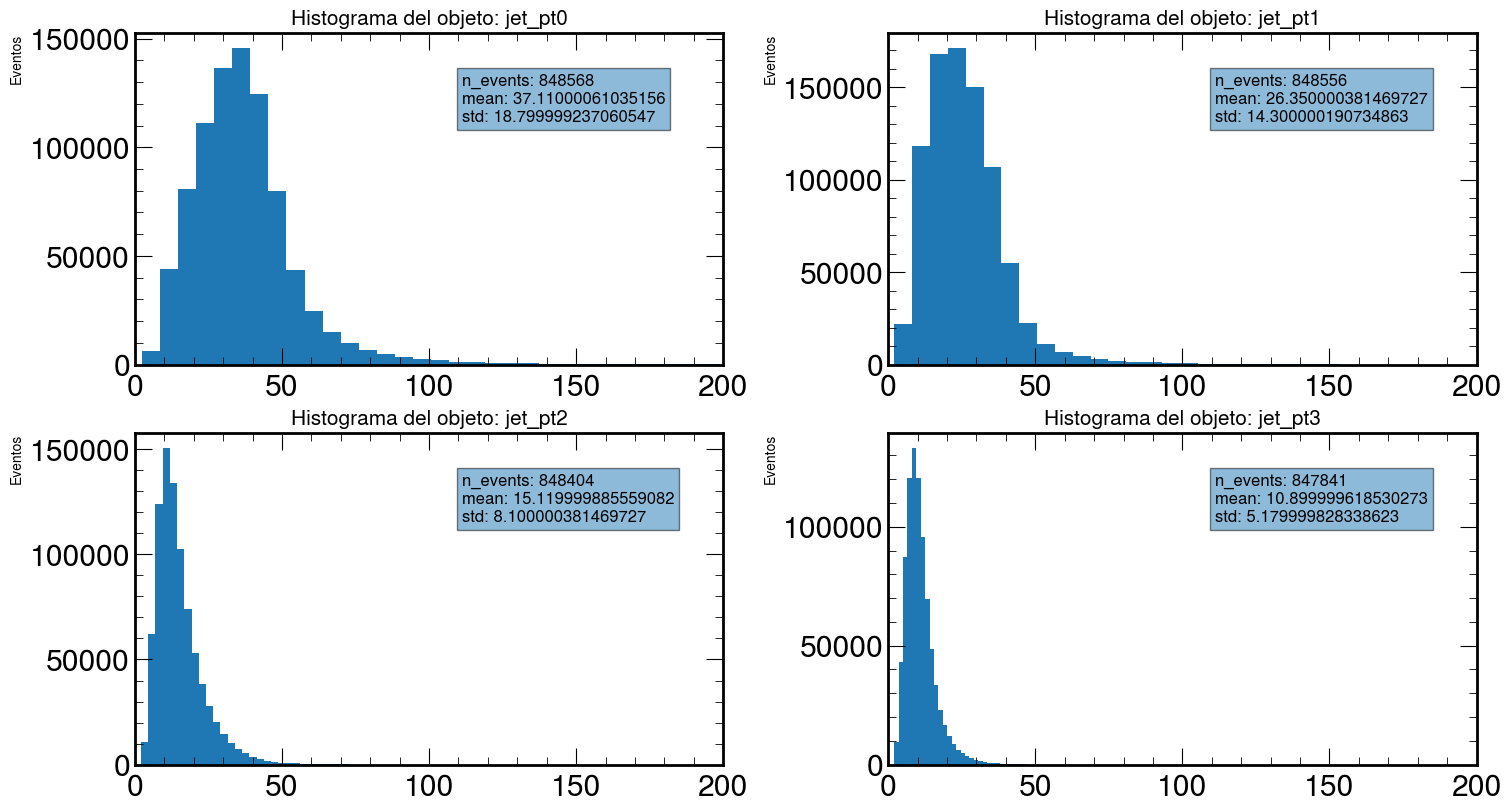

In [7]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,"jet_pt0",0,200,100)
plt.subplot(2,2,2)
pt_jet(df_all,"jet_pt1",0,200,100)
plt.subplot(2,2,3)
pt_jet(df_all,"jet_pt2",0,200,100)
plt.subplot(2,2,4)
pt_jet(df_all,"jet_pt3",0,200,100)

## Hitogramas de $\eta$

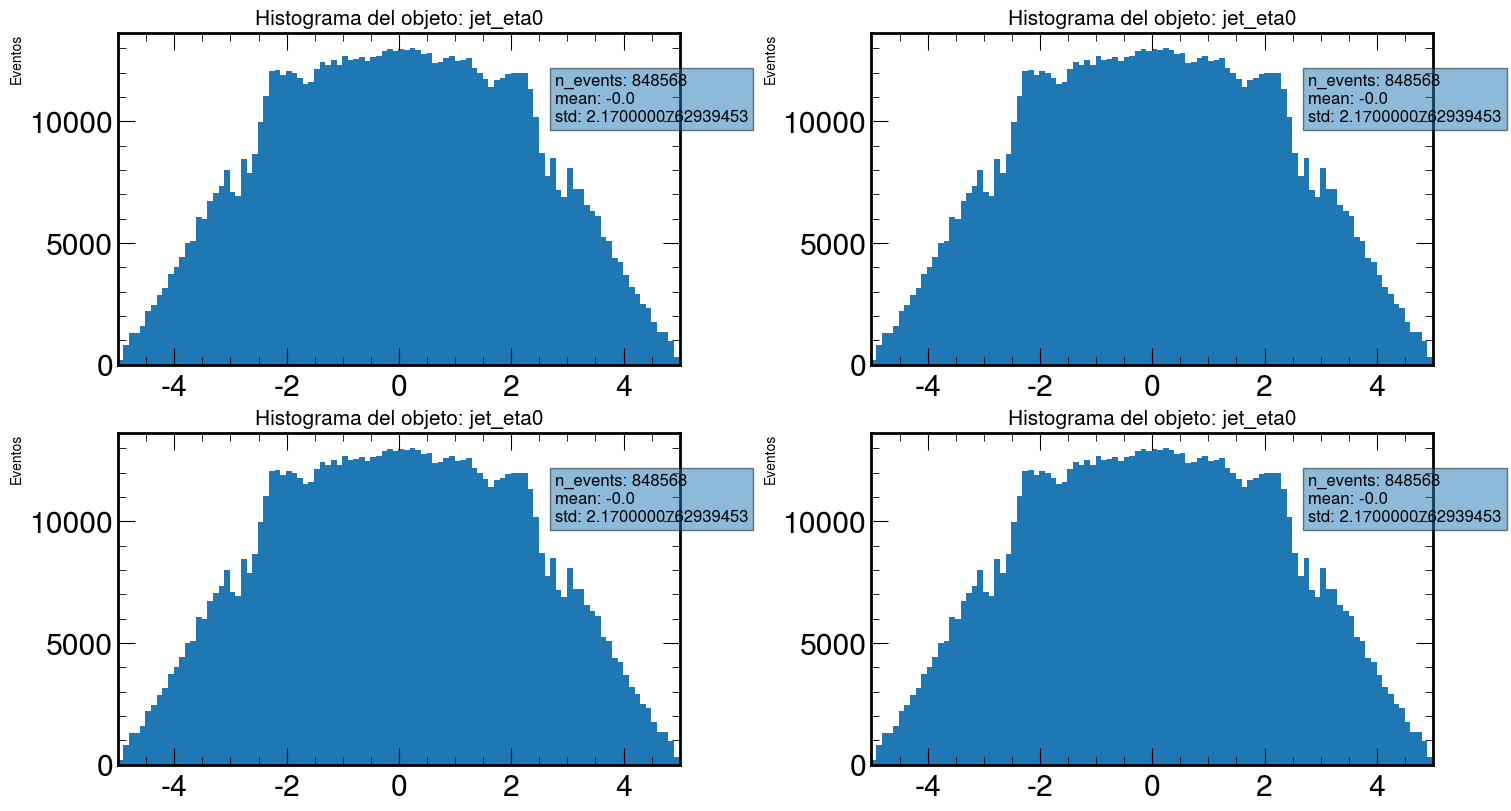

In [8]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,2)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,3)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,4)
pt_jet(df_all,'jet_eta0',-5,5,100)

## Hitogramas de $\phi$

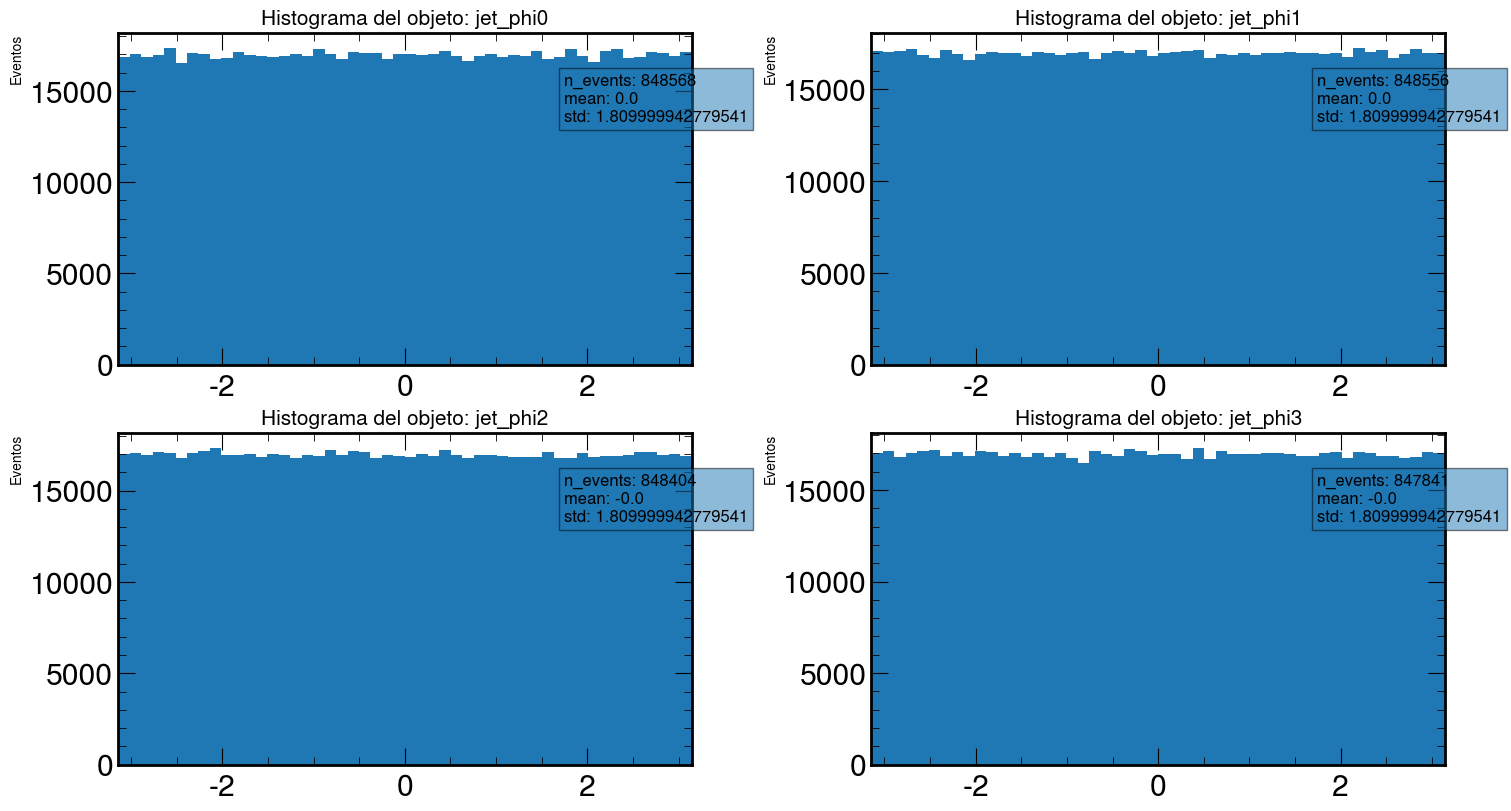

In [9]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,'jet_phi0',-np.pi,np.pi,50)
plt.subplot(2,2,2)
pt_jet(df_all,'jet_phi1',-np.pi,np.pi,50)
plt.subplot(2,2,3)
pt_jet(df_all,'jet_phi2',-np.pi,np.pi,50)
plt.subplot(2,2,4)
pt_jet(df_all,'jet_phi3',-np.pi,np.pi,50)

## Analisis para los b-jets (b1,b2) en la run_01
Eventos con 2 jets taggeados como b

In [ ]:
f = df_all[["jet_btag0","jet_btag1","jet_btag2","jet_btag3"]]
f_list = [ sum(f.loc[i]) for i in range(len(f)) ]
df_all.insert(1,"n_jets",f_list)

In [73]:
data_filtered = df_all[df_all["n_jets"] == 2]
print("Numero de eventos con 2 jets:",len(data_filtered))
data2 = data_filtered[["n_jets","jet_btag0","jet_btag1","jet_btag2","jet_btag3","jet_pt0","jet_pt1","jet_pt2","jet_pt3","jet_phi0","jet_phi1","jet_phi2","jet_phi3"]]
data2.head()

Numero de eventos con 2 jets: 157166


,n_jets,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_phi0,jet_phi1,jet_phi2,jet_phi3
6,2.0,1.0,0.0,0.0,1.0,19.393379,10.207476,6.240767,5.777122,1.385800,-2.078976,1.814955,-0.925352
8,2.0,1.0,1.0,0.0,0.0,32.055767,31.602999,6.987425,6.673363,2.976409,-0.026138,1.112091,-1.416556
21,2.0,1.0,1.0,0.0,0.0,30.307781,26.745689,22.093033,6.491794,-1.337182,1.421419,-2.111089,1.345422
31,2.0,1.0,1.0,0.0,0.0,40.389709,16.412298,10.564023,8.602764,0.193683,-2.966999,1.543302,-2.347492
47,2.0,1.0,1.0,0.0,0.0,45.631542,34.100296,11.894100,10.977970,-1.166278,1.899346,-2.886641,0.397737


In [28]:
a = data2.shape[0]/2
steps = []
for _ in range(2):
    b = a*_
    d = a*(_+1)
    c = [int(b),int(d)]
    steps.append(c)

In [29]:
steps

[[0, 78583], [78583, 157166]]

In [31]:
data_bjet_dict = {"jet_pt_b1":[],"jet_pt_b2":[],
                  "jet_eta_b1":[],"jet_eta_b2":[],
                  "jet_phi_b1":[],"jet_phi_b2":[],
                  "jet_mass_b1":[],"jet_mass_b2":[]}# diccionario vacio
data_bjet = pd.DataFrame(data_bjet_dict)
data_bjet.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2


In [30]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [ ]:
for k in range(11):
    printProgressBar(k,10)
    a = steps[k][0]
    b = steps[k][1]
    tag_pt = []
    tag_eta = []
    tag_phi = []
    tag_mass = []
    print(steps[k])
    for i in range(a,b):
        pt = []
        eta = []
        phi = []
        mass = []
        printProgressBar(i,b-1)
        if data2.iloc[i][0] == 1.0: 
            pt.append(data_filtered.jet_pt0.to_list()[i])
            eta.append(data_filtered.jet_eta0.to_list()[i])
            phi.append(data_filtered.jet_phi0.to_list()[i])
            mass.append(data_filtered.jet_mass0.to_list()[i])
        if data2.iloc[i][1] == 1.0: 
            pt.append(data_filtered.jet_pt1.to_list()[i])
            eta.append(data_filtered.jet_eta1.to_list()[i])
            phi.append(data_filtered.jet_phi1.to_list()[i])
            mass.append(data_filtered.jet_mass1.to_list()[i])
        if data2.iloc[i][2] == 1.0: 
            pt.append(data_filtered.jet_pt2.to_list()[i])
            eta.append(data_filtered.jet_eta2.to_list()[i])
            phi.append(data_filtered.jet_phi2.to_list()[i])
            mass.append(data_filtered.jet_mass2.to_list()[i])
        if data2.iloc[i][3] == 1.0: 
            pt.append(data_filtered.jet_pt3.to_list()[i])
            eta.append(data_filtered.jet_eta3.to_list()[i])
            phi.append(data_filtered.jet_phi3.to_list()[i])
            mass.append(data_filtered.jet_mass3.to_list()[i])
        tag_pt.append(pt)
        tag_eta.append(eta)
        tag_phi.append(phi)
        tag_mass.append(mass)


    jet_pt_b1 = [j[0] for j in tag_pt]
    jet_pt_b2 = [j[1] for j in tag_pt]
    jet_eta_b1 = [j[0] for j in tag_eta]
    jet_eta_b2 = [j[1] for j in tag_eta]
    jet_phi_b1 = [j[0] for j in tag_phi]
    jet_phi_b2 = [j[1] for j in tag_phi]
    jet_mass_b1 = [j[0] for j in tag_mass]
    jet_mass_b2 = [j[1] for j in tag_mass]


    di = {"jet_pt_b1":jet_pt_b1,"jet_pt_b2":jet_pt_b2,
        "jet_eta_b1":jet_eta_b1,"jet_eta_b2":jet_eta_b2,
        "jet_phi_b1":jet_phi_b1,"jet_phi_b2":jet_phi_b2,
        "jet_mass_b1":jet_mass_b1,"jet_mass_b2":jet_mass_b2}

    data_bjet = pd.concat([data_bjet,pd.DataFrame(di,index=None)])
    data_bjet.to_csv("bjet.csv",index=None)
    print("se actualizo el dataset")

In [63]:
pd.read_csv("bjet.csv")

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905
...,...,...,...,...,...,...,...,...
157161,43.540634,35.185070,-1.001356,-0.547007,-1.108244,1.957038,7.621053,4.746550
157162,43.887745,43.814110,1.861606,2.034532,0.682071,-2.211828,5.369121,7.442794
157163,15.268529,5.943544,-0.972348,2.400573,-0.949661,1.847808,2.268107,1.191547
157164,9.515949,8.215191,-3.969439,-0.101742,-1.328923,1.556560,1.627742,1.306148


In [64]:
phi_cor = []
for i in range(len(data_bjet)):
    phi_cor.append(AbsDeltaPhi(i,data_bjet,"jet_phi_b1","jet_phi_b2"))

data_bjet['Delta_eta_b'] = data_bjet.jet_eta_b2 - data_bjet.jet_eta_b1
data_bjet['Delta_phi_b'] = phi_cor
data_bjet["DeltaR_b"] = DeltaR(data_bjet.Delta_eta_b,data_bjet.Delta_phi_b)

In [66]:
data_bjet.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,DeltaR_b,y1,y2,inv_mass_b,inv_mass_b_eta
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425,-2.791015,2.311151,3.623698,1.004405,-1.762369,44.050044,44.541771
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526,-0.292647,3.002547,3.016774,-1.824208,-2.126606,64.234149,64.187694
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203,-1.639062,2.758601,3.208800,0.359219,-1.271122,76.165222,76.393794
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398,-1.575201,3.122503,3.497325,0.109897,-1.455080,68.076743,68.305309
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905,0.944458,3.065624,3.207811,-0.988140,-0.053067,87.623294,87.803805


In [67]:
data_bjet.shape

(157166, 15)

In [69]:
data_bjet.to_csv("data_bjet_all.csv",index=None)

## Histogramas para los pT(b1,b2)

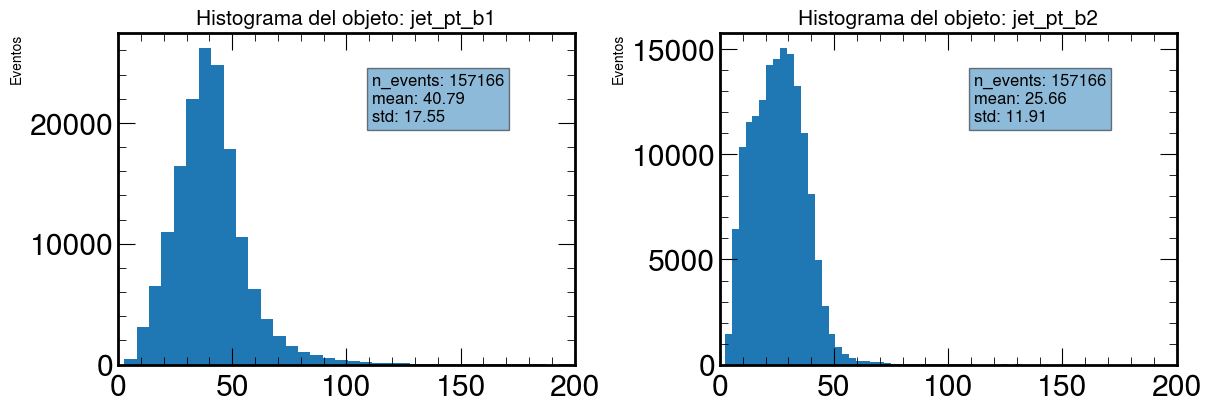

In [40]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,"jet_pt_b1",0,200,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,"jet_pt_b2",0,200,100)

## Histogramas para los $\eta$(b1,b2)

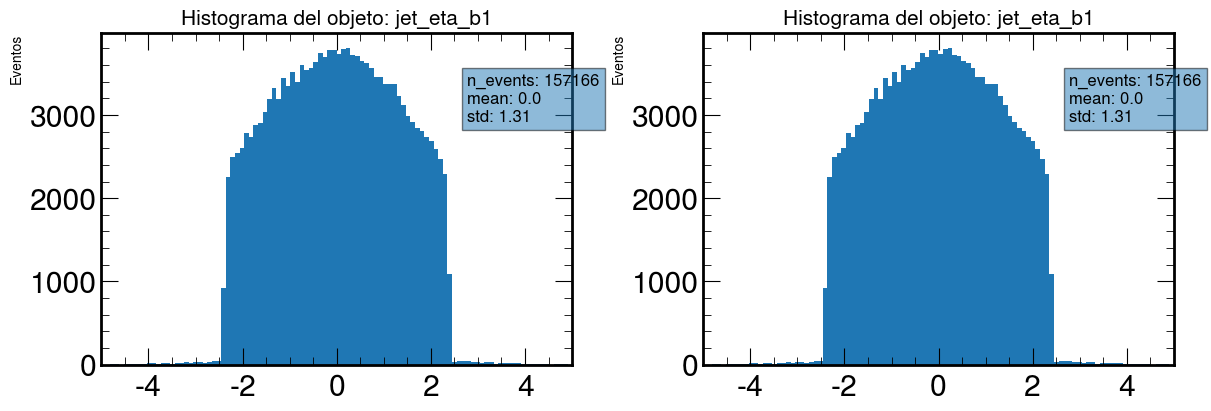

In [41]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'jet_eta_b1',-5,5,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'jet_eta_b1',-5,5,100)

## Histogramas para los $\phi$(b1,b2)

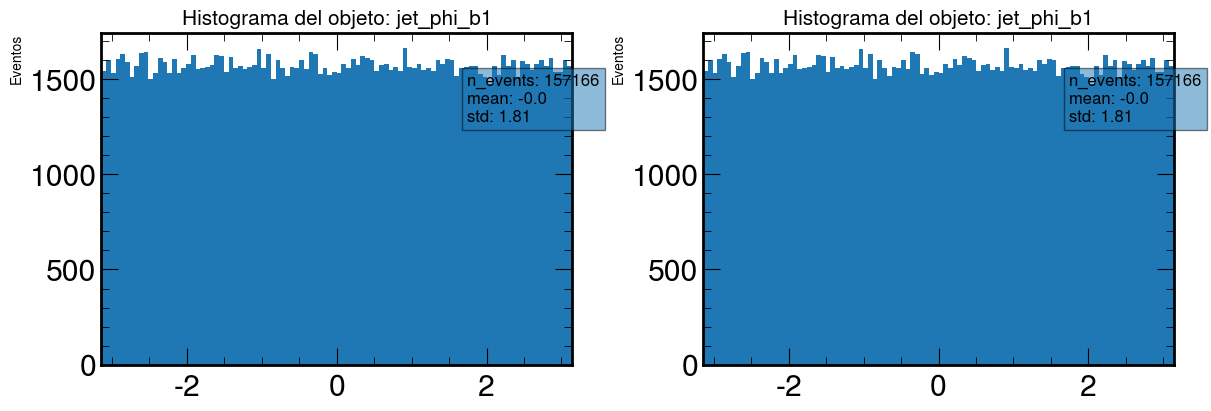

In [42]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'jet_phi_b1',-np.pi,np.pi,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'jet_phi_b1',-np.pi,np.pi,100)

## Histogramas para el $\Delta R$

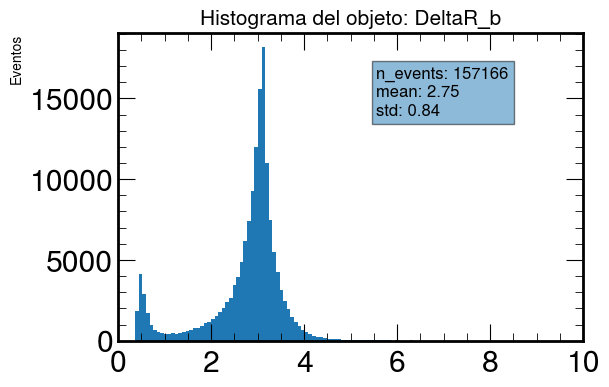

In [43]:
plt.figure(figsize=(6,4))
pt_jet(data_bjet,"DeltaR_b",0,10,100)

## Histogramas para los $\Delta \phi$, $\Delta \eta$
Notamos que el $\Delta \phi$ esta definido de 0 hasta $\pi$ y se grafica positivo debido a como esta definido el valor absoluto de esta cantidad

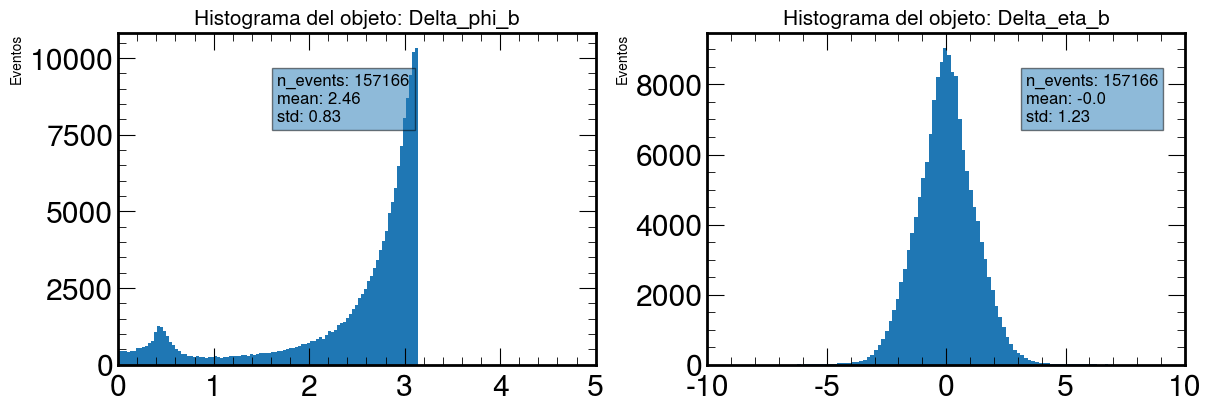

In [44]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'Delta_phi_b',0,5,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'Delta_eta_b',-10,10,100)

## Rapidez "$y$" en terminos de $\eta$
$\begin{equation}
y = ln \left ( \frac{\sqrt{m^{2} + p_{T}^{2}cosh^{2}(\eta)}+ p_{T}sinh(\eta)}{\sqrt{m^{2} + p_{T}^{2}}} \right )
\end{equation}$

referencia: [rapidez de particulas](https://hmong.es/wiki/Pseudorapidity)]

In [45]:
def y(m,eta,pt):
    return np.log( (np.sqrt(m**2 + (pt**2)*(np.cosh(eta)**2)) + pt*np.sinh(eta)) / (np.sqrt(m**2 + pt**2)) )

y1 = y(data_bjet.jet_mass_b1,data_bjet.jet_eta_b1,data_bjet.jet_pt_b1)
y2 = y(data_bjet.jet_mass_b2,data_bjet.jet_eta_b2,data_bjet.jet_pt_b2)

data_bjet['y1'] = y1
data_bjet['y2'] = y2

In [46]:
data_bjet.to_csv("data_bjet_all.csv",index=False)

## Histogramas de Rapidez $y(b1)=y1$,$y(b2)=y2$

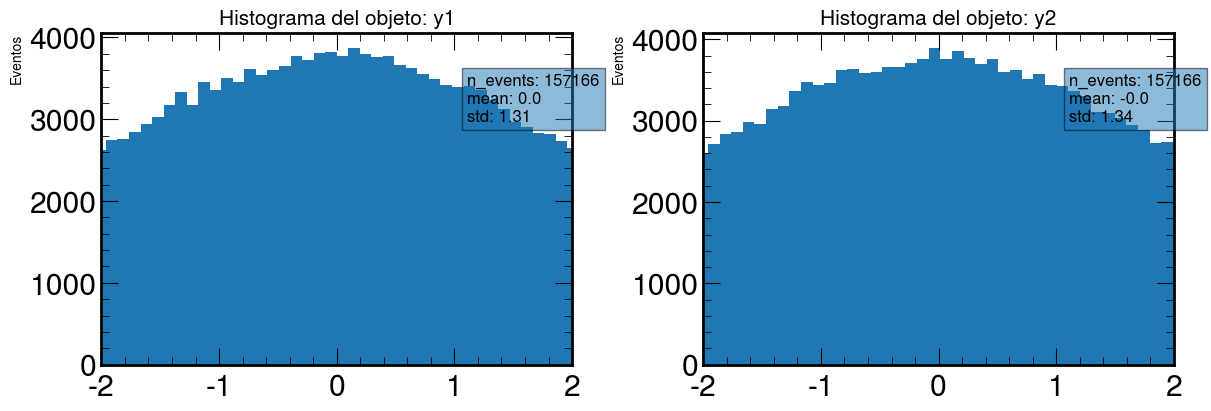

In [47]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'y1',-2,2,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'y2',-2,2,100)

## Masa invariante en Colisionadores de particulas:

$\begin{equation}
M^{2} = 2P_{T1}P_{T2}[ cosh(y_{1} - y_{2}) - cos(\phi _{1} - \phi _{2}) ]
\end{equation}$

In [48]:
def inv_mass(pt1,pt2,y1,y2,Dphi):
    return np.sqrt(2*pt1*pt2*(np.cosh(y1 - y2) - np.cos(Dphi)))

inv_m = inv_mass(data_bjet.jet_pt_b1,data_bjet.jet_pt_b2,
                 data_bjet.y1,data_bjet.y2,
                 data_bjet.Delta_phi_b)

data_bjet["inv_mass_b"] = inv_m # agregamos al dataset la masa invariante.

def inv_mass(pt1,pt2,Deta,Dphi):
    return np.sqrt(2*pt1*pt2*(np.cosh(Deta) - np.cos(Dphi)))

inv_m = inv_mass(data_bjet.jet_pt_b1,data_bjet.jet_pt_b2,
                 data_bjet.Delta_eta_b,
                 data_bjet.Delta_phi_b)

data_bjet["inv_mass_b_eta"] = inv_m # agregamos al dataset la masa invariante.

In [49]:
data_bjet.to_csv("data_bjet_all.csv",index=False)

## Histograma para Masa invariante usando definicion de $y$ (izquierda) y usando la definicion de $\eta$ (derecha)

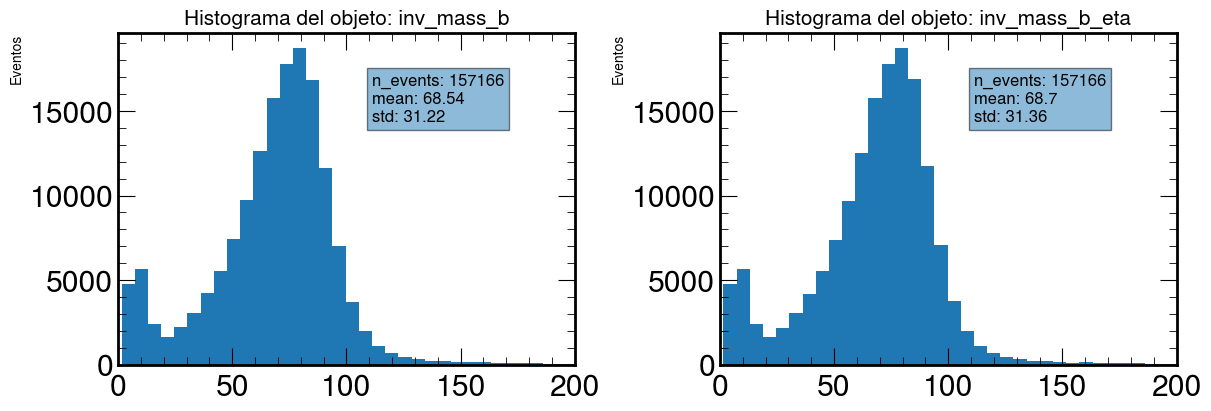

In [50]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,"inv_mass_b",0,200,200)
plt.subplot(1,2,2)
pt_jet(data_bjet,"inv_mass_b_eta",0,200,200)

## MET

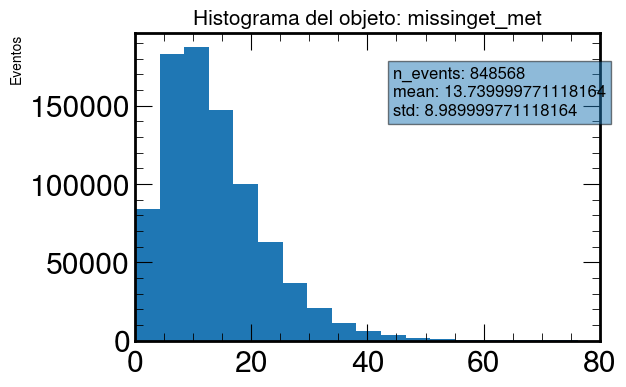

In [51]:
plt.figure(figsize=(6,4))
pt_jet(df_all,'missinget_met',0,80,200)

# Eficiencia de corte

In [74]:
b0 = []
b1 = []
j0 = []
j1 = []
for i in range(len(data2)):
    b0_temp = data_before_c1.iloc[i][4]
    b1_temp = data_before_c1.iloc[i][5]
    j0_temp = data2.iloc[i][9]
    j1_temp = data2.iloc[i][10]
    
    b0.append(b0_temp)
    b1.append(b1_temp)
    j0.append(j0_temp)
    j1.append(j1_temp)

In [77]:
def eff_corte(before,after):
    return len(after)/len(before)

def pross(n_pros,b0,b1,j0,j1):
    pross = []
    if n_pros == 1:
        for i in range(len(data2)):
            if b0[i] != j0[i]:
                pross.append([b0[i],j0[i]]) # b0_j0
            else: pross.append(0)
    if n_pros == 2:
        for i in range(len(data2)):
            if b1[i] != j0[i]:
                pross.append([b1[i],j0[i]]) # b1_j0
            else: pross.append(0)
    if n_pros == 3:
        for i in range(len(data2)):
            if b0[i] != j1[i]:
                pross.append([b0[i],j1[i]]) # b0_j1
            else: pross.append(0)
    if n_pros == 4:
        for i in range(len(data2)):
            if b1[i] != j1[i]:
                pross.append([b1[i],j1[i]])
            else: pross.append(0)
    return pross

In [78]:
pross1 = pross(1,b0,b1,j0,j1)
pross2 = pross(2,b0,b1,j0,j1)
pross3 = pross(3,b0,b1,j0,j1)
pross4 = pross(4,b0,b1,j0,j1)

In [79]:
data_before_c1 = data_bjet
data_before_c1["pross1"] = pross1
data_before_c1["pross2"] = pross2
data_before_c1["pross3"] = pross3
data_before_c1["pross4"] = pross4

data_before_c1["jet_phi0"] = data2.jet_phi0.tolist()
data_before_c1["jet_phi1"] = data2.jet_phi1.tolist()
data_before_c1["jet_phi2"] = data2.jet_phi2.tolist()
data_before_c1["jet_phi3"] = data2.jet_phi3.tolist()
data_before_c1.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,...,inv_mass_b,inv_mass_b_eta,pross1,pross2,pross3,pross4,jet_phi0,jet_phi1,jet_phi2,jet_phi3
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425,-2.791015,2.311151,...,44.050044,44.541771,0,"[-0.9253517985343933, 1.385799527168274]","[1.385799527168274, -2.0789761543273926]","[-0.9253517985343933, -2.0789761543273926]",1.385800,-2.078976,1.814955,-0.925352
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526,-0.292647,3.002547,...,64.234149,64.187694,0,"[-0.02613767981529236, 2.9764089584350586]","[2.9764089584350586, -0.02613767981529236]",0,2.976409,-0.026138,1.112091,-1.416556
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203,-1.639062,2.758601,...,76.165222,76.393794,0,"[1.4214187860488892, -1.3371819257736206]","[-1.3371819257736206, 1.4214187860488892]",0,-1.337182,1.421419,-2.111089,1.345422
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398,-1.575201,3.122503,...,68.076743,68.305309,0,"[-2.9669992923736572, 0.19368323683738708]","[0.19368323683738708, -2.9669992923736572]",0,0.193683,-2.966999,1.543302,-2.347492
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905,0.944458,3.065624,...,87.623294,87.803805,0,"[1.8993457555770874, -1.16627836227417]","[-1.16627836227417, 1.8993457555770874]",0,-1.166278,1.899346,-2.886641,0.397737


## Primer corte: $N_{b} = 2$, $P_{T}(b)>5$, $|\eta(b)| < 2.5$
los $N_{b} = 2$ son los eventos que se consideraron con 2 jets, estos se realizo en el anterior análisis. 

In [81]:
data_after_c1 = data_bjet[(data_bjet.jet_pt_b1 > 5) & (data_bjet.jet_pt_b2 > 5) & (abs(data_bjet.jet_eta_b1) < 2.5) & (abs(data_bjet.jet_eta_b2) < 2.5)]
data_after_c1.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,...,inv_mass_b,inv_mass_b_eta,pross1,pross2,pross3,pross4,jet_phi0,jet_phi1,jet_phi2,jet_phi3
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425,-2.791015,2.311151,...,44.050044,44.541771,0,"[-0.9253517985343933, 1.385799527168274]","[1.385799527168274, -2.0789761543273926]","[-0.9253517985343933, -2.0789761543273926]",1.385800,-2.078976,1.814955,-0.925352
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526,-0.292647,3.002547,...,64.234149,64.187694,0,"[-0.02613767981529236, 2.9764089584350586]","[2.9764089584350586, -0.02613767981529236]",0,2.976409,-0.026138,1.112091,-1.416556
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203,-1.639062,2.758601,...,76.165222,76.393794,0,"[1.4214187860488892, -1.3371819257736206]","[-1.3371819257736206, 1.4214187860488892]",0,-1.337182,1.421419,-2.111089,1.345422
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398,-1.575201,3.122503,...,68.076743,68.305309,0,"[-2.9669992923736572, 0.19368323683738708]","[0.19368323683738708, -2.9669992923736572]",0,0.193683,-2.966999,1.543302,-2.347492
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905,0.944458,3.065624,...,87.623294,87.803805,0,"[1.8993457555770874, -1.16627836227417]","[-1.16627836227417, 1.8993457555770874]",0,-1.166278,1.899346,-2.886641,0.397737


In [82]:
print("La eficiencia para el primer corte es:", eff_corte(data_before_c1,data_after_c1))

La eficiencia para el primer corte es: 0.9730285176183144


## Segundo corte: $\Delta R(b_{1},b_{2}) < 3.5$

In [83]:
data_before_c2 = data_after_c1

In [84]:
data_after_c2 = data_before_c2[(data_before_c2.DeltaR_b < 3.5)]
data_after_c2.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,...,inv_mass_b,inv_mass_b_eta,pross1,pross2,pross3,pross4,jet_phi0,jet_phi1,jet_phi2,jet_phi3
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526,-0.292647,3.002547,...,64.234149,64.187694,0,"[-0.02613767981529236, 2.9764089584350586]","[2.9764089584350586, -0.02613767981529236]",0,2.976409,-0.026138,1.112091,-1.416556
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203,-1.639062,2.758601,...,76.165222,76.393794,0,"[1.4214187860488892, -1.3371819257736206]","[-1.3371819257736206, 1.4214187860488892]",0,-1.337182,1.421419,-2.111089,1.345422
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398,-1.575201,3.122503,...,68.076743,68.305309,0,"[-2.9669992923736572, 0.19368323683738708]","[0.19368323683738708, -2.9669992923736572]",0,0.193683,-2.966999,1.543302,-2.347492
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905,0.944458,3.065624,...,87.623294,87.803805,0,"[1.8993457555770874, -1.16627836227417]","[-1.16627836227417, 1.8993457555770874]",0,-1.166278,1.899346,-2.886641,0.397737
5,56.929878,39.888947,-0.897075,0.815759,0.249652,-2.496700,10.289511,5.267717,1.712834,2.746351,...,130.323388,131.119608,0,"[-2.496699571609497, 0.24965161085128784]","[0.24965161085128784, -2.496699571609497]",0,0.249652,-2.496700,-2.168490,0.907437


In [86]:
print("La eficiencia para el segundo corte es:", eff_corte(data_before_c2,data_after_c2))

La eficiencia para el segundo corte es: 0.92185160239853


## Tercer corte: $m_{b1,b2} < 50$

In [87]:
data_before_c3 = data_after_c2

In [96]:
data_after_c3 = data_before_c3[(data_before_c3.inv_mass_b < 50) & (data_before_c3.inv_mass_b_eta < 50)].reset_index()
data_after_c3.drop("index",axis=1,inplace=True)
data_after_c3.head(10)

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,...,inv_mass_b,inv_mass_b_eta,pross1,pross2,pross3,pross4,jet_phi0,jet_phi1,jet_phi2,jet_phi3
0,22.238794,20.841276,0.530937,1.747003,-0.445206,0.262520,4.680990,3.537635,1.216066,0.707727,...,31.506104,31.571670,"[-0.4452064335346222, 3.0107200145721436]","[0.26252010464668274, 3.0107200145721436]",0,"[0.26252010464668274, -0.4452064335346222]",3.010720,-0.445206,0.262520,1.908483
1,28.850031,7.613652,1.364405,1.589443,-2.467250,-2.990445,5.790969,1.479867,0.225038,0.523195,...,8.364421,8.362904,0,"[-2.9904446601867676, -2.467249870300293]","[-2.467249870300293, 0.4786534309387207]","[-2.9904446601867676, 0.4786534309387207]",-2.467250,0.478653,-1.095865,-2.990445
2,75.119392,23.361349,0.800018,0.202338,0.652844,0.696416,5.695681,4.556839,-0.597680,0.043572,...,25.555690,25.477430,0,"[0.6964161396026611, 0.6528444886207581]","[0.6528444886207581, -2.4066152572631836]","[0.6964161396026611, -2.4066152572631836]",0.652844,-2.406615,0.696416,-2.127368
3,29.302998,15.770082,-0.212805,-0.095042,-0.441010,-0.924416,4.767639,1.904579,0.117763,0.483406,...,10.587529,10.597933,"[-0.4410095512866974, 2.1438517570495605]","[-0.9244157075881958, 2.1438517570495605]",0,"[-0.9244157075881958, -0.4410095512866974]",2.143852,-0.441010,-0.924416,-1.746954
4,22.118122,14.628027,-1.933400,-2.037964,2.224194,2.678802,2.792423,0.000000,-0.104564,0.454609,...,8.354410,8.322478,"[2.224193811416626, -0.6634061932563782]","[2.678802490234375, -0.6634061932563782]",0,"[2.678802490234375, 2.224193811416626]",-0.663406,2.224194,2.678802,2.362573
5,26.829123,9.700256,1.124120,0.158574,1.628139,-1.886546,3.264445,0.411303,-0.965546,2.768501,...,35.551175,35.598594,"[1.6281391382217407, -1.5054306983947754]","[-1.8865456581115723, -1.5054306983947754]",0,"[-1.8865456581115723, 1.6281391382217407]",-1.505431,1.628139,-1.886546,-2.732713
6,23.873981,20.378473,-1.152566,-2.042781,2.142433,-2.568795,3.820323,4.025971,-0.890215,1.571957,...,37.119464,37.227135,"[2.1424334049224854, 1.874752402305603]","[-2.5687949657440186, 1.874752402305603]","[2.1424334049224854, -1.2773809432983398]","[-2.5687949657440186, -1.2773809432983398]",1.874752,-1.277381,2.142433,-2.568795
7,58.417671,13.581120,0.839591,0.664149,1.539236,2.164301,3.820789,1.727994,-0.175442,0.625065,...,18.038821,18.013825,0,"[2.1643009185791016, 1.539236307144165]","[1.539236307144165, 2.823301315307617]","[2.1643009185791016, 2.823301315307617]",1.539236,2.823301,-0.450282,2.164301
8,26.261583,18.321507,-0.553332,-0.987943,-0.395844,-0.652799,2.035526,3.401493,-0.434611,0.256955,...,10.914299,11.131787,0,"[-0.6527989506721497, -0.3958437740802765]","[-0.3958437740802765, 2.48726487159729]","[-0.6527989506721497, 2.48726487159729]",-0.395844,2.487265,-0.652799,2.801003
9,30.389675,12.804542,1.983392,1.088431,2.545238,-0.834760,3.411311,2.252333,-0.894960,2.903187,...,43.270849,43.214919,"[2.545238494873047, -0.6428253054618835]","[-0.834760308265686, -0.6428253054618835]",0,"[-0.834760308265686, 2.545238494873047]",-0.642825,2.545238,-0.834760,2.087066


In [97]:
print("La eficiencia para el tercer corte es:", eff_corte(data_before_c3,data_after_c3))

La eficiencia para el tercer corte es: 0.20558109181704687


# Cut Analysis

1. $| \Delta \phi(j0,j1)|$

2. $| \Delta \phi(j0,j2)|$

3. $| \Delta \phi(j0,j3)|$

4. $| \Delta \phi(j1,j2)|$

5. $| \Delta \phi(j1,j3)|$

6. $| \Delta \phi(j2,j3)|$

7. $| \Delta \phi(b0,b1)|$

8. $| \Delta \phi(b0,j0)|$ con b0 y j0 no siendo el mismo jet

9. $| \Delta \phi(b0,j1)|$ con b0 y j1 no siendo el mismo jet

10. $| \Delta \phi(b1,j0)|$ con b1 y j0 no siendo el mismo jet

11. $| \Delta \phi(b1,j1)|$ con b1 y j1 no siendo el mismo jet

In [98]:
dic_Dphi = {"j0_j1":[],"j0_j2":[],"j0_j3":[],"j1_j2":[],"j1_j3":[],"j2_j3":[],"b0_b1":[],"b0_j0":[],"b0_j1":[],"b1_j0":[],"b1_j1":[]}
df_Dphi = pd.DataFrame(dic_Dphi)
df_Dphi.head()

,j0_j1,j0_j2,j0_j3,j1_j2,j1_j3,j2_j3,b0_b1,b0_j0,b0_j1,b1_j0,b1_j1


In [99]:
phi_cor_1 = []
for i in range(len(data_after_c3)):
    phi_cor_1.append(AbsDeltaPhi(i,data_after_c3,"jet_phi0","jet_phi1")) # j0_j1

phi_cor_2 = []
for i in range(len(data_after_c3)):
    phi_cor_2.append(AbsDeltaPhi(i,data_after_c3,"jet_phi0","jet_phi2")) # j0_j2
    
phi_cor_3 = []
for i in range(len(data_after_c3)):
    phi_cor_3.append(AbsDeltaPhi(i,data_after_c3,"jet_phi0","jet_phi3")) # j0_j3

phi_cor_4 = []
for i in range(len(data_after_c3)):
    phi_cor_4.append(AbsDeltaPhi(i,data_after_c3,"jet_phi1","jet_phi2")) # j1_j2
    
phi_cor_5 = []
for i in range(len(data_after_c3)):
    phi_cor_5.append(AbsDeltaPhi(i,data_after_c3,"jet_phi1","jet_phi3")) # j1_j3
        
phi_cor_6 = []
for i in range(len(data_after_c3)):
    phi_cor_6.append(AbsDeltaPhi(i,data_after_c3,"jet_phi2","jet_phi3")) # j2_j3
    
phi_cor_7 = []
for i in range(len(data_after_c3)):
    phi_cor_7.append(AbsDeltaPhi(i,data_after_c3,"jet_phi_b1","jet_phi_b2")) # b0_b1

In [100]:
def DeltaPhi_2(d1,d2):
    dphi = d1 - d2
    if dphi >= np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def AbsDeltaPhi_2(d1,d2):
    return np.abs(DeltaPhi_2(d1,d2))  

In [101]:
phi_cor_8 = []
for i in range(len(data_after_c3)):
    if data_after_c3.pross1[i] == 0:
        phi_cor_8.append(np.nan)
    else:
        d_temp = data_after_c3.pross1[i]
        phi_cor_8.append(AbsDeltaPhi_2(d_temp[0],d_temp[1])) # b0_j0
        
phi_cor_9 = []
for i in range(len(data_after_c3)):
    if data_after_c3.pross2[i] == 0:
        phi_cor_9.append(np.nan)
    else:
        d_temp = data_after_c3.pross2[i]
        phi_cor_9.append(AbsDeltaPhi_2(d_temp[0],d_temp[1])) # b1_j0
        
phi_cor_10 = []
for i in range(len(data_after_c3)):
    if data_after_c3.pross3[i] == 0:
        phi_cor_10.append(np.nan)
    else:
        d_temp = data_after_c3.pross3[i]
        phi_cor_10.append(AbsDeltaPhi_2(d_temp[0],d_temp[1])) # b0_j1
        
phi_cor_11 = []
for i in range(len(data_after_c3)):
    if data_after_c3.pross4[i] == 0:
        phi_cor_11.append(np.nan)
    else:
        d_temp = data_after_c3.pross4[i]
        phi_cor_11.append(AbsDeltaPhi_2(d_temp[0],d_temp[1])) # b1_j1

In [103]:
df_Dphi["j0_j1"] = phi_cor_1
df_Dphi["j0_j2"] = phi_cor_2
df_Dphi["j0_j3"] = phi_cor_3
df_Dphi["j1_j2"] = phi_cor_4
df_Dphi["j1_j3"] = phi_cor_5
df_Dphi["j2_j3"] = phi_cor_6
df_Dphi["b0_b1"] = phi_cor_7
df_Dphi["b0_j0"] = phi_cor_8
df_Dphi["b0_j1"] = phi_cor_10
df_Dphi["b1_j0"] = phi_cor_9
df_Dphi["b1_j1"] = phi_cor_11

In [104]:
df_Dphi.head()

,j0_j1,j0_j2,j0_j3,j1_j2,j1_j3,j2_j3,b0_b1,b0_j0,b0_j1,b1_j0,b1_j1
0,2.827259,2.748200,1.102237,0.707727,2.353690,1.645963,0.707727,2.827259,NaN,2.748200,0.707727
1,2.945903,1.371385,0.523195,1.574518,2.814087,1.894580,0.523195,NaN,2.945903,0.523195,2.814087
2,3.059460,0.043572,2.780213,3.103031,0.279247,2.823785,0.043572,NaN,3.059460,0.043572,3.103031
3,2.584861,3.068267,2.392379,0.483406,1.305945,0.822538,0.483406,2.584861,NaN,3.068267,0.483406
4,2.887600,2.940977,3.025979,0.454609,0.138379,0.316230,0.454609,2.887600,NaN,2.940977,0.454609


# Histogramas del Analisis de $\Delta \phi$ dados los cortes

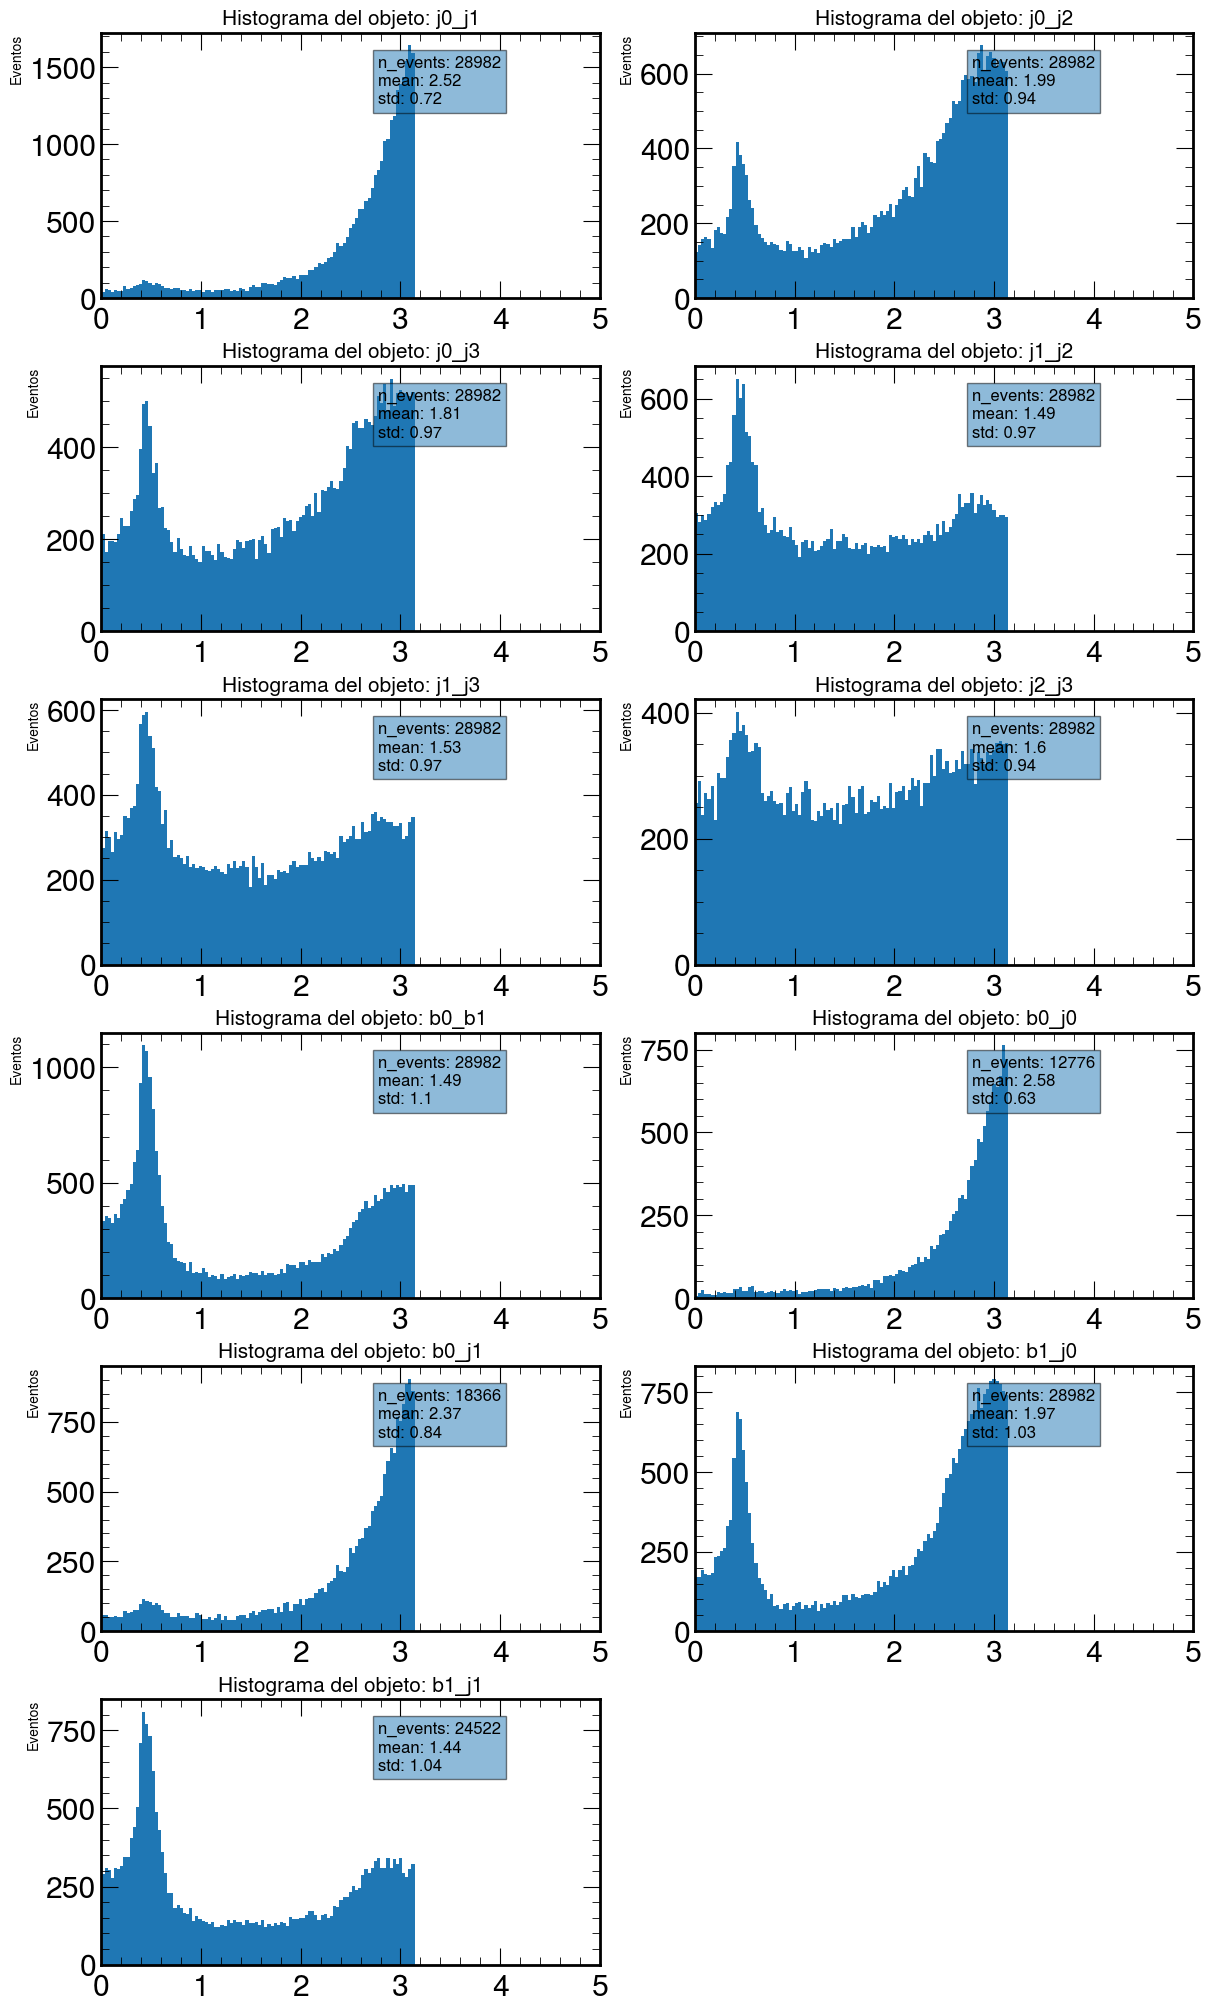

In [105]:
plt.figure(figsize=(12,20),constrained_layout=True)

plt.subplot(6,2,1)
pt_jet(df_Dphi,'j0_j1',0,5,100)
plt.subplot(6,2,2)
pt_jet(df_Dphi,'j0_j2',0,5,100)
plt.subplot(6,2,3)
pt_jet(df_Dphi,'j0_j3',0,5,100)
plt.subplot(6,2,4)
pt_jet(df_Dphi,'j1_j2',0,5,100)
plt.subplot(6,2,5)
pt_jet(df_Dphi,'j1_j3',0,5,100)
plt.subplot(6,2,6)
pt_jet(df_Dphi,'j2_j3',0,5,100)
plt.subplot(6,2,7)
pt_jet(df_Dphi,'b0_b1',0,5,100)
plt.subplot(6,2,8)
pt_jet(df_Dphi,'b0_j0',0,5,100)
plt.subplot(6,2,9)
pt_jet(df_Dphi,'b0_j1',0,5,100)
plt.subplot(6,2,10)
pt_jet(df_Dphi,'b1_j0',0,5,100)
plt.subplot(6,2,11)
pt_jet(df_Dphi,'b1_j1',0,5,100)